In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
DATA_FOLDER = "../data"
ABUNDANCE_FILE = "abundance_with_unique_diff.csv"
ABUNDANCE_START = 212

abundance_data = pd.read_csv(os.path.join(DATA_FOLDER, ABUNDANCE_FILE), low_memory=False)

In [3]:
datasets = abundance_data['dataset_name'].unique()
datasets

array(['Candela_Africa', 'Chatelier_gut_obesity', 'doyle_bt2', 'hmp',
       'hmpii', 'Loman2013_EcoliOutbreak_DNA_HiSeq',
       'Loman2013_EcoliOutbreak_DNA_MiSeq', 'metahit',
       'Neilsen_genome_assembly', 'Psoriasis_2014',
       'Quin_gut_liver_cirrhosis', 'Segre_Human_Skin',
       'Tito_subsistence_gut', 't2dmeta_long', 't2dmeta_short',
       'VerticalTransmissionPilot', 'WT2D',
       'Zeller_fecal_colorectal_cancer'], dtype=object)

In [4]:
abundance = {}

for dataset in datasets:
    abundance[dataset] = abundance_data[abundance_data['dataset_name'] == dataset]
    
    print("The dataset, ", dataset, " has: ", abundance[dataset].shape[0], " samples")
    print(abundance[dataset]['disease'].value_counts())

The dataset,  Candela_Africa  has:  38  samples
disease
n    38
Name: count, dtype: int64
The dataset,  Chatelier_gut_obesity  has:  278  samples
disease
obesity    164
leaness     89
n           25
Name: count, dtype: int64
The dataset,  doyle_bt2  has:  458  samples
disease
nd    458
Name: count, dtype: int64
The dataset,  hmp  has:  762  samples
disease
n    762
Name: count, dtype: int64
The dataset,  hmpii  has:  219  samples
disease
n    219
Name: count, dtype: int64
The dataset,  Loman2013_EcoliOutbreak_DNA_HiSeq  has:  44  samples
disease
stec2-positive    43
 -                 1
Name: count, dtype: int64
The dataset,  Loman2013_EcoliOutbreak_DNA_MiSeq  has:  9  samples
disease
stec2-positive    9
Name: count, dtype: int64
The dataset,  metahit  has:  110  samples
disease
n                         85
ibd_ulcerative_colitis    21
ibd_crohn_disease          4
Name: count, dtype: int64
The dataset,  Neilsen_genome_assembly  has:  382  samples
disease
n                         187
i

In [5]:
# Psoriasis-2014 dataset
dataset_name = 'Quin_gut_liver_cirrhosis'

data_subset = abundance[dataset_name]
data_abundance = data_subset.iloc[:, ABUNDANCE_START:]

positive_indices = data_subset[data_subset['disease'] == 'cirrhosis'].index
positive_unique_ids = data_subset.loc[positive_indices, 'UniqueID'].values

negative_indices = data_subset[data_subset['disease'] == 'n'].index
negative_unique_ids = data_subset.loc[negative_indices, 'UniqueID'].values

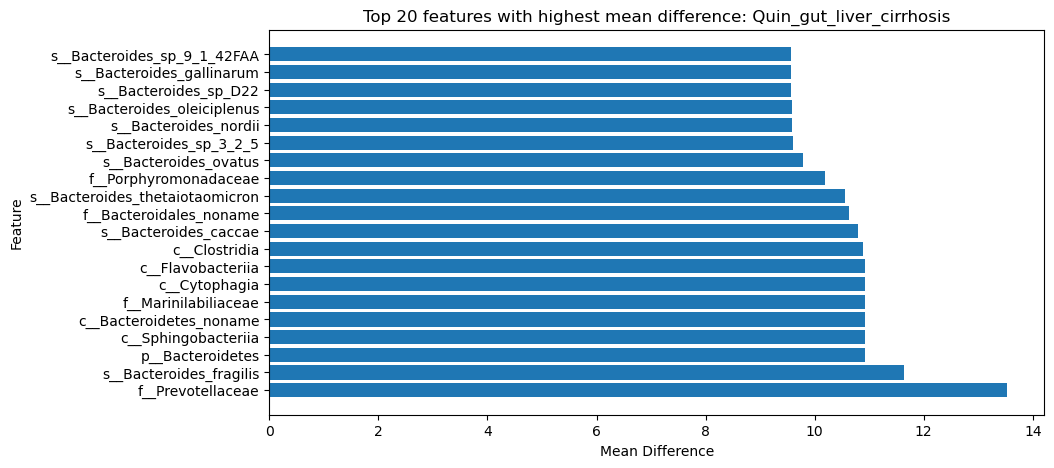

In [7]:
# Find average abundance of all the positive samples column-wise
positive_set = data_abundance.loc[positive_indices]
positive_mean = positive_set.mean(axis=0)

# Find average abundance of all the negative samples column-wise
negative_set = data_abundance.loc[negative_indices]
negative_mean = negative_set.mean(axis=0)

diff_mean = abs(positive_mean - negative_mean)
diff_mean_sorted = diff_mean.sort_values(ascending=False)

# Plot the top 20 features with bar in x-axis and feature name in y-axis

top_features = diff_mean_sorted.index[:20]

plt.figure(figsize=(10, 5))
plt.barh(top_features, diff_mean_sorted[:20])
plt.xlabel('Mean Difference')
plt.ylabel('Feature')
plt.title(f'Top 20 features with highest mean difference: {dataset_name}')
plt.savefig(f"../images/{dataset_name}_top_20_features_diff_mean.png")
plt.show()

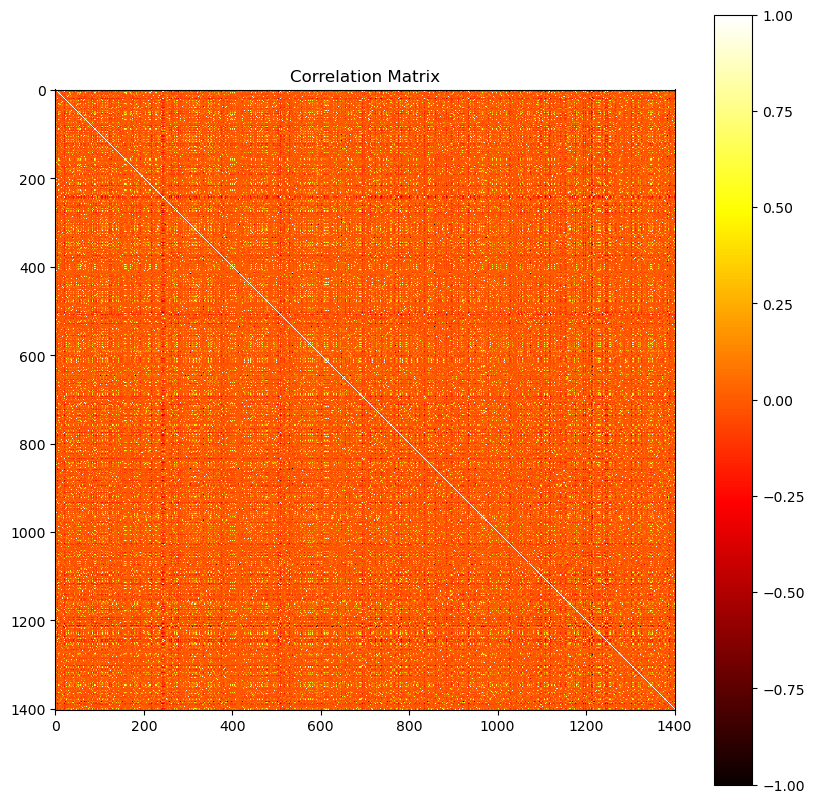

In [8]:
# Create a new np.array with 0 and 1 from the abundance data disease column

target = data_subset['disease'].apply(lambda x: 1 if x == 'y' else 0).values

data_abundance_non_zero_cols = data_abundance.columns[(data_abundance != 0).any()]
data_abundance_non_zero = data_abundance[data_abundance_non_zero_cols]

data_abundance_numpy = data_abundance_non_zero.values

# Find correlation between the features

correlation_matrix = np.corrcoef(data_abundance_numpy, rowvar=False)

# Plot the correlation matrix

plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.title('Correlation Matrix')
plt.savefig(f"../images/{dataset_name}_correlation_matrix.png")
plt.show()

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DiseaseDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.n_classes = len(np.unique(target))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_subset, test_size=0.2, random_state=42)

top_features = diff_mean_sorted.index[:200]

In [14]:
train_data_X = train_data[top_features].values
train_data_target = pd.Categorical(train_data['disease']).codes

test_data_X = test_data[top_features].values
test_data_target = pd.Categorical(test_data['disease']).codes

train_dataset = DiseaseDataset(train_data_X, target=train_data_target)
test_dataset = DiseaseDataset(test_data_X, target=test_data_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 185
Number of testing samples: 47


In [15]:
# Define the model = Neural Network Classifier

class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

In [16]:
input_dim = train_data_X.shape[1]
output_dim = train_dataset.n_classes

model = Classifier(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(1000):
    model.train()
    running_loss = 0.0
    for i, (data, target) in enumerate(train_loader):
        data, target = data.float().to(device), target.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        running_loss += loss.item()
        
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {running_loss}")

Epoch: 0, Loss: 4.176501095294952
Epoch: 100, Loss: 2.4128398001194
Epoch: 200, Loss: 2.217422753572464
Epoch: 300, Loss: 2.1453610360622406
Epoch: 400, Loss: 2.110649734735489
Epoch: 500, Loss: 2.106164038181305
Epoch: 600, Loss: 2.0971047282218933
Epoch: 700, Loss: 2.1018769443035126
Epoch: 800, Loss: 2.080692619085312
Epoch: 900, Loss: 2.0875511169433594


In [17]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred = []
    true = []
    for data, target in test_loader:
        data, target = data.float().to(device), target.type(torch.LongTensor).to(device)
        
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        
        pred.extend(predicted.cpu().numpy())
        true.extend(target.cpu().numpy())
        
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    print(f'Accuracy: {100 * correct / total}')

Accuracy: 82.97872340425532
